In [1]:
import re
import pandas as pd
import numpy as np
from string import ascii_uppercase
import itertools
import random
import matplotlib.pyplot as plt

### Load data and preprocess

In [2]:
source_dir = "../data/fig14a/"
source_file  = "kmeans_50_rep_50sec_variation.csv"

class InFile(object):
    """Process strings as the file is being loaded"""
    
    def __init__(self, infile):
        self.infile = open(infile)

    def __next__(self):
        return self.next()

    def __iter__(self):
        return self

    def read(self, *args, **kwargs):
        return self.__next__()

    def next(self):
        try:
            line = self.infile.readline()
            
            line = re.sub(r'  +', r',', line) 
            line = re.sub(r' ', r',', line) 

            return line
        except:
            self.infile.close()
            raise StopIteration

x = pd.read_csv(InFile(source_dir + source_file), header=0)

# Name specific columns
x.columns = range(8)
x.rename({0: "Use-Case", 4: "Runtime"}, axis=1, inplace=True)

x["timestamp"] = pd.to_datetime(x[1] + " " + x[2])

# The file has 50 records fo network A, followed by 50 records for network B, etc.
x["Network"] = list(itertools.chain(*[[el] * 50 for el in list(ascii_uppercase)]))[:len(x)]

hibench50 = x[["Use-Case", "Runtime", "timestamp", "Network"]]
print "Number of records:", len(hibench50)

hibench50.sample(10)

Number of records: 400


,Use-Case,Runtime,timestamp,Network
382,ScalaSparkKmeans,198.312,2019-03-11 01:25:52,H
113,ScalaSparkKmeans,133.843,2019-03-10 03:03:19,C
10,ScalaSparkKmeans,250.357,2019-03-09 18:12:57,A
54,ScalaSparkKmeans,163.526,2019-03-09 23:05:19,B
137,ScalaSparkKmeans,127.465,2019-03-10 04:30:25,C
168,ScalaSparkKmeans,512.969,2019-03-10 08:09:27,D
314,ScalaSparkKmeans,160.794,2019-03-10 20:12:32,G
216,ScalaSparkKmeans,136.608,2019-03-10 13:49:39,E
393,ScalaSparkKmeans,145.387,2019-03-11 02:17:24,H
202,ScalaSparkKmeans,126.183,2019-03-10 12:58:22,E


### Confidence Intervals: Estimation and Plotting 

In [3]:
def ci_p(s, p):
    """ 
    For values in the given array s and p in [0, 1], this fuction returns 
    empirical p-quantile value and its nonparametric 95% confidence interval.
    
    Refer to book by Boudec: https://infoscience.epfl.ch/record/146812/files/perfPublisherVersion_1.pdf,
    (Page 36 describes how nonparametric confidence intervals can be obtained for p-quantiles)
    """
    n = len(s)
    q = np.quantile(s, p)
    eta = 1.96 # for gamma = 0.95
    
    lo_rank = max(int(np.floor(n * p - eta * np.sqrt(n * p * (1-p)))), 0)
    hi_rank = min(int(np.ceil(n * p + eta * np.sqrt(n * p * (1-p))) + 1), n-1)
    
    s_sorted = sorted(s.tolist())
    q_ci_lo = s_sorted[lo_rank]
    q_ci_hi = s_sorted[hi_rank]
    
    return q, q_ci_lo, q_ci_hi

# Test for median
print ci_p(hibench50["Runtime"][:20], 0.5)

(297.9765, 282.392, 367.811)


#### Medians for HiBench

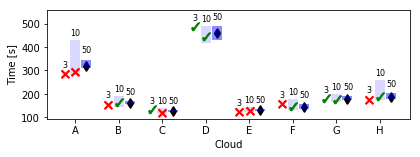

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(6.5, 2))

n_list = []
for n_idx, (n, grp) in enumerate(hibench50.groupby("Network")):
    df = pd.DataFrame()
    n_list.append(n)
    
    for r in [10, len(grp)]:
        
        med, ci_lo, ci_hi = ci_p(np.array(grp["Runtime"].tolist()[:r]), 0.5)        
        df = pd.concat([df, pd.DataFrame([{"Reps": r, "Med": med, "CI Lo": ci_lo, "CI Hi": ci_hi}])])

    
    # Vis results for 10
    ax.errorbar(n_idx * 4 + 1, df["Med"].tolist()[0], 
                yerr=[np.array([df["Med"].tolist()[0]-df["CI Lo"].tolist()[0]]), 
                      np.array([df["CI Hi"].tolist()[0]-df["Med"].tolist()[0]])], 
                     c="blue", fmt='', lw = 10, alpha=0.15)
    
    if df["CI Lo"].tolist()[-1] <= df["Med"].tolist()[0] <= df["CI Hi"].tolist()[-1]:
        ax.plot(n_idx * 4 + 1-0.075, df["Med"].tolist()[0], "green", alpha=1.0, marker=ur'$\u2713$', markersize=10)
    else:
        ax.plot(n_idx * 4 + 1-0.075, df["Med"].tolist()[0], "red", alpha=1.0, marker="$\\times$", markersize=10)
    
    plt.annotate("10", xy=(n_idx * 4 + 1 - 0.45, df["CI Hi"].tolist()[0] + 20), fontsize=8)
    
    # Vis results for 50
    ax.errorbar(n_idx * 4 + 2.0, df["Med"].tolist()[-1], yerr=[np.array([df["Med"].tolist()[-1]-df["CI Lo"].tolist()[-1]]), 
                                                 np.array([df["CI Hi"].tolist()[-1]-df["Med"].tolist()[-1]])], \
                     c="blue", fmt='', lw = 10, alpha=0.45)
    ax.scatter(n_idx * 4 + 2.0, df["Med"].tolist()[-1], c='black', marker="d", lw =2.0)
    
    plt.annotate("50", xy=(n_idx * 4 + 2.0 - 0.4, df["CI Hi"].tolist()[-1] + 30), fontsize=8)

    # Vis results for 3
    if df["CI Lo"].tolist()[-1] <= np.median(grp["Runtime"].tolist()[:3]) <= df["CI Hi"].tolist()[-1]:
        ax.plot(n_idx * 4 -0.075, np.median(grp["Runtime"].tolist()[:3]), "green", alpha=1.0, marker=ur'$\u2713$', markersize=10)
    else:
        ax.plot(n_idx * 4 -0.075, np.median(grp["Runtime"].tolist()[:3]), "red", alpha=1.0, marker="$\\times$", markersize=10)
    plt.annotate("3", xy=(n_idx * 4 - 0.2, np.median(grp["Runtime"].tolist()[:3]) + 30), fontsize=8)

# Additional styling
ax.set_xticks(np.array(range(n_idx + 1)) * 4 + 1.0)
ax.set_xticklabels(n_list)
ax.set_ylim([ax.get_ylim()[0], ax.get_ylim()[1] * 1.1])
ax.set_ylabel("Time [s]")
ax.set_xlabel("Cloud");